# Modules for building the autoencoder models

In [1]:
import writefile_run
models_file = 'modules.py'

In [2]:
%%writefile_run $models_file

import torch
from torch import nn
from torch import optim
import torch.functional as F
import numpy as np

In [3]:
DEVICE = torch.device('cuda')
torch.backends.cudnn.benchmark = True

In [4]:
from pylab import *

In [5]:
rcParams['figure.figsize']=18,7
rcParams['font.size']=15
rcParams['axes.grid']=True

style.use('dark_background')

In [6]:
from lines_curves_dataset import *

## Get a dataset to test modules

In [7]:
batch_size = 32
batches_per_epoch = 1000

In [8]:
dset = LinesCurvesDataset(imgs_per_epoch=batch_size*batches_per_epoch, 
                          nlines_range=(1, 2), 
                          ncurves_range=(0, 2), 
                          nellipses_range=(0, 2), 
                          x_range=(0, 64), 
                          y_range=(0, 64), 
                          dilation_size_range=(2, 5), 
                          img_size=(64, 64), 
                          blur_sigma=0.5, 
                          device=DEVICE)

In [9]:
train_loader = DataLoader(dset, batch_size = batch_size, shuffle=True)


loader = iter(train_loader)

torch.Size([1, 64, 64])


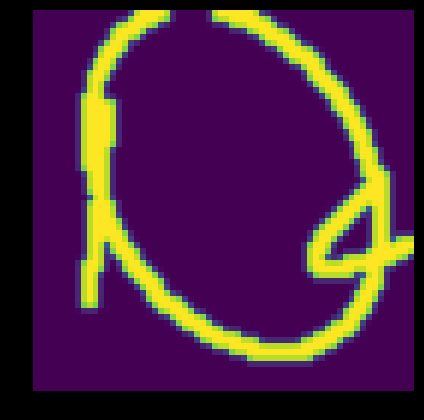

In [10]:
sample_inp = dset[0]
print(sample_inp.shape)
axis('off')
imshow(sample_inp.cpu().numpy().transpose([1,2,0]).squeeze())

# Modules

## Block of convs with a residual connection

In [11]:
%%writefile_run $models_file -a


class ConvBlock(nn.Module):
    """One block of convolutions with a residual connection"""
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        
        assert kernel_size%2==1, "kernel_size should be odd number"
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding = kernel_size//2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding = kernel_size//2)
        
        self.bn1_1 = nn.BatchNorm2d(in_channels)
        self.bn1_2 = nn.BatchNorm2d(out_channels)
        
        self.bn2_1 = nn.BatchNorm2d(out_channels)
        self.bn2_2 = nn.BatchNorm2d(out_channels)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        if self.out_channels != self.in_channels:
            self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
            self.res_bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = self.bn1_1(x)
        
        out = self.conv1(x)
        out = self.bn1_2(out)
        out = nn.ReLU()(out)
        
        out = self.bn2_1(out)
        out = self.conv2(out)
        out = self.bn2_2(out)
        
        if self.out_channels != self.in_channels:
            residual = self.res_conv(residual)
            residual = self.res_bn(residual)
        
        out = nn.ReLU()(out+residual)
            
        return out

In [12]:
test = nn.Sequential(
    ConvBlock(1, 16),
    ConvBlock(16, 32),
).to(DEVICE)

inp = next(loader)
print(inp.shape)
out = test(next(loader))
print(out.shape)

torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 64, 64])


## Block of deconvs with a residual connection

In [13]:
%%writefile_run $models_file -a


class DeconvBlock(nn.Module):
    """One block of transposed convolutions with a residual connection"""
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        
        assert kernel_size%2==1, "kernel_size should be odd number"
        
        self.deconv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, padding = kernel_size//2)
        self.deconv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, padding = kernel_size//2)
        
        self.bn1_1 = nn.BatchNorm2d(in_channels)
        self.bn1_2 = nn.BatchNorm2d(out_channels)
        
        self.bn2_1 = nn.BatchNorm2d(out_channels)
        self.bn2_2 = nn.BatchNorm2d(out_channels)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        if self.out_channels != self.in_channels:
            self.res_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1)
            self.res_bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = self.bn1_1(x)
        
        out = self.deconv1(x)
        out = self.bn1_2(out)
        out = nn.ReLU()(out)
        
        out = self.bn2_1(out)
        out = self.deconv2(out)
        out = self.bn2_2(out)
        
        if self.out_channels != self.in_channels:
            residual = self.res_conv(residual)
            residual = self.res_bn(residual)
        
        out = nn.ReLU()(out+residual)
           
        return out

In [14]:
test = nn.Sequential(
    DeconvBlock(1, 8),
    DeconvBlock(8, 16),
).to(DEVICE)

inp = next(loader)
print(inp.shape)
out = test(next(loader))
print(out.shape)

torch.Size([32, 1, 64, 64])
torch.Size([32, 16, 64, 64])


## A set of cascaded blocks

In [15]:
%%writefile_run $models_file -a


class BlockSet(nn.Module):
    """Cascades a set of given blocks. The first block maps in_channels to 
    out_channels, and remaining blocks map out_channels to out_channels."""
    def __init__(self, block, in_channels, out_channels, block_count, kernel_size=3):
        super().__init__()
        
        block1 = block(in_channels, out_channels, kernel_size=kernel_size)
        blocks = [block(out_channels, out_channels, kernel_size=kernel_size) for _ in range(block_count-1)]
        
        self.blocks = nn.Sequential(block1, *blocks)
            
    def forward(self, input):
        out = self.blocks(input)
        
        return out

In [16]:
convtest = BlockSet(ConvBlock, 
                in_channels=1, 
                out_channels=8, 
                block_count=2).to(DEVICE)

inp = next(loader)
out = convtest(inp)

print(inp.shape)
print(out.shape)

torch.Size([32, 1, 64, 64])
torch.Size([32, 8, 64, 64])


In [17]:
deconvtest = BlockSet(DeconvBlock, 
                in_channels=1, 
                out_channels=8, 
                block_count=2).to(DEVICE)

inp = next(loader)
out = deconvtest(inp)
print(inp.shape)
print(out.shape)

torch.Size([32, 1, 64, 64])
torch.Size([32, 8, 64, 64])


## A network of cascaded BlockSets

In [18]:
%%writefile_run $models_file -a


class BlockNet(nn.Module):
    """
    Cascades multiple BlockSets to form a complete network. One BlockSet is used for each element in
    the channel_sequence, and size scaling is done between blocks based on size_sequence. A decrease in
    size is done using fractional max pooling, and an increase in size is done by bilinear upsampling.
    
    A final 1x1 block is added after all the BlockSets.
    """
    def __init__(self, block, channel_sequence, size_sequence, block_count, kernel_size=3, use_block_for_last=False):
        super().__init__()
        
        assert len(channel_sequence)==len(size_sequence), "channel and size sequences should have same length"
        
        old_channels, old_size = channel_sequence[0], size_sequence[0]
        
        layers = []
        for channels, size in zip(channel_sequence[1:], size_sequence[1:]):
            layers.append(BlockSet(block, 
                                   in_channels=old_channels,
                                   out_channels=channels,
                                   block_count=block_count,
                                   kernel_size=kernel_size))
            if size<old_size:
                layers.append(nn.FractionalMaxPool2d(kernel_size=kernel_size, output_size=size))
            elif size>old_size:
                layers.append(nn.Upsample(size=(size,size), mode='bilinear', align_corners=True))
            
            old_channels, old_size = channels, size
        
        if use_block_for_last:
            layers.append(block(channels, channels, kernel_size=1))
        else:
            layers.append(nn.Conv2d(channels, channels, kernel_size=1))
        
        self.layers = nn.Sequential(*layers)
                
            
            
    def forward(self, input):
        out = self.layers(input)
        return out

In [19]:
encodertest = BlockNet(ConvBlock, 
                   channel_sequence=[1,64,64,128,128], 
                   size_sequence=[64,32,16,8,1], 
                   block_count=5,
                   kernel_size=3).to(DEVICE)
# print(encoder)
print(nn.utils.parameters_to_vector(encodertest.parameters()).shape)

# inp = next(loader)
# encoded = encodertest(inp)
# print(inp.shape)
# print(encoded.shape)

torch.Size([3620674])


In [20]:
decodertest = BlockNet(DeconvBlock, 
                   channel_sequence=[128,128,128,64,1], 
                   size_sequence=[1,8,16,32,64], 
                   block_count=5,
                   kernel_size=3).to(DEVICE)
# print(encoder)
print(nn.utils.parameters_to_vector(decodertest.parameters()).shape)

# out = decodertest(encoded)
# print(encoded.shape)
# print(out.shape)

torch.Size([3380038])


## Autoencoder wrapper

In [21]:
%%writefile_run $models_file -a


class Autoencoder(nn.Module):
    """Combines an encoder and decoder into an autoencoder
    Can supply `return_embedding` as true to get back the embedding as well"""
    def __init__(self, encoder, decoder, output_activation=nn.LeakyReLU()):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.out_act = output_activation
        
    def forward(self, input, return_embedding=False):
        embedding = self.encoder(input)
        output = self.out_act(self.decoder(embedding))
        
        if return_embedding:
            return output, embedding
        
        return output

In [22]:
%%writefile_run $models_file -a


class NormalizeModule(nn.Module):
    """Returns (input-mean)/std"""
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
        
    def forward(self, input):
        return (input-self.mean)/self.std

# Coord Conv

In [23]:
%%writefile_run $models_file -a


class CoordConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=0):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels+2, out_channels, kernel_size=kernel_size, padding=padding)
        
    def forward(self, input):
        h = input.shape[2]
        w = input.shape[3]
        
#         print(input.shape)
        
        i = np.linspace(-1,1,h)
        j = np.linspace(-1,1,w)
        
        ii,jj = np.meshgrid(i,j)
        
       
        ii = torch.tensor(ii, dtype=input.dtype).to(input.device).repeat((input.shape[0],1,1,1))
        jj = torch.tensor(jj, dtype=input.dtype).to(input.device).repeat((input.shape[0],1,1,1))
        
#         print(ii.device,jj)
        
        inp = torch.cat([input, ii, jj], dim=1)
        
        out = self.conv(inp)
        
        return out

In [24]:
cc = CoordConv(1, 4).to(DEVICE)

testin = dset[0].unsqueeze(0)
out = cc(testin)
out.shape, out

(torch.Size([1, 4, 62, 62]),
 tensor([[[[ 0.1873,  0.1699,  0.1525,  ..., -0.8383, -0.8557, -0.8731],
           [ 0.1984,  0.1810,  0.1636,  ..., -0.8272, -0.8445, -0.8619],
           [ 0.2095,  0.1922,  0.1748,  ..., -0.8160, -0.8334, -0.8508],
           ...,
           [ 0.8442,  0.8269,  0.8095,  ..., -0.1813, -0.1987, -0.2161],
           [ 0.8554,  0.8380,  0.8206,  ..., -0.1702, -0.1876, -0.2050],
           [ 0.8665,  0.8491,  0.8317,  ..., -0.1591, -0.1764, -0.1938]],
 
          [[-0.6564, -0.6558, -0.6553,  ..., -0.6243, -0.6238, -0.6232],
           [-0.6397, -0.6392, -0.6386,  ..., -0.6077, -0.6071, -0.6066],
           [-0.6231, -0.6225, -0.6220,  ..., -0.5910, -0.5905, -0.5899],
           ...,
           [ 0.3255,  0.3261,  0.3266,  ...,  0.3576,  0.3582,  0.3587],
           [ 0.3422,  0.3427,  0.3433,  ...,  0.3743,  0.3748,  0.3753],
           [ 0.3588,  0.3594,  0.3599,  ...,  0.3909,  0.3914,  0.3920]],
 
          [[-0.3113, -0.3079, -0.3045,  ..., -0.1109, -0.

## Block of coord convs with a residual connection

In [25]:
%%writefile_run $models_file -a


class CoordConvBlock(nn.Module):
    """One block of convolutions with a residual connection. Convolutions are 'CoordConvs'.
    They add coordinate meshgrids to input channels."""
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        
        assert kernel_size%2==1, "kernel_size should be odd number"
        
        self.cconv1 = CoordConv(in_channels, out_channels, kernel_size, padding = kernel_size//2)
        self.cconv2 = CoordConv(out_channels, out_channels, kernel_size, padding = kernel_size//2)
        
        self.bn1_1 = nn.BatchNorm2d(in_channels)
        self.bn1_2 = nn.BatchNorm2d(out_channels)
        
        self.bn2_1 = nn.BatchNorm2d(out_channels)
        self.bn2_2 = nn.BatchNorm2d(out_channels)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        if self.out_channels != self.in_channels:
            self.res_cconv = CoordConv(in_channels, out_channels, kernel_size=1)
            self.res_bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = self.bn1_1(x)
        
        out = self.cconv1(x)
        out = self.bn1_2(out)
        out = nn.ReLU()(out)
        
        out = self.bn2_1(out)
        out = self.cconv2(out)
        out = self.bn2_2(out)
        
        if self.out_channels != self.in_channels:
            residual = self.res_cconv(residual)
            residual = self.res_bn(residual)
        
        out = nn.ReLU()(out+residual)
            
        return out

In [26]:
test = nn.Sequential(
    CoordConvBlock(1, 8),
    CoordConvBlock(8, 16),
).to(DEVICE)

inp = next(loader)
print(inp.shape)
out = test(next(loader))
print(out.shape)

torch.Size([32, 1, 64, 64])
torch.Size([32, 16, 64, 64])
